# IMDB Rocemmender System

# 1. Reading Data & Importing Library

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\saeed\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


###  Reading Movies Data & Rating Data

In [2]:
movies_df = pd.read_csv('movies.csv')

ratings_df = pd.read_csv('ratings.csv')

### Show Movies &  Ratings data head

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# 2. Preprocessing
### Now we clean data an prepare it.
### In this section we have to do a few things.
##### Movies Data

- remove date from title and Add a new column called Year.
- Split the contents of the genre column and add new columns with genre titles.

##### Ratings Data

- Remove timestamp column

### 2.1. Add Year Column

In [5]:
#Extracting the years
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)

#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)

#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')

#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

movies_df.head()

C:\Users\saeed\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


### 2.2. Add genres Column
#### this techniqu called One Hot Encoding
- In this technique, we consider a column for each genre.
- Then, for each film in the genre, we enter the number 1 in the matrix
- If the movie is not in the genre, it has the value of null, which we fill with 0.
- This technique is commonly used in the analysis of recommender systems and finding frequent patterns.

In [6]:
#Every genre is separated by a | so we simply have to call the split function on |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [7]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres_df = movies_df.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Now we have the movies with genres data.we can use this in future

### 2.3. Drop timestamp Column from ratings data

In [8]:
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

C:\Users\saeed\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# 3. Content-Based recommendation system
- This technique allows vendors to identify preferences by the attributes of the product(s) that customers have bought or intend to buy. Knowing these preferences, the vendor recommends to customers products with similar attributes. For instance, the system may recommend a text-mining book to a customer who has shown interest in data mining, or action movies after a consumer has rented one in this category.

### 3.1. Create user input data
- creating an input user to recommend movies

In [9]:
userInput = [
            {'title':'Lord of the Rings: The Fellowship of the Ring', 'rating':5},
            {'title':'Lord of the Rings: The Two Towers', 'rating':5},
            {'title':'Lord of the Rings: The Return of the King', 'rating':5},
            {'title':'Hobbit: An Unexpected Journey', 'rating':5},
            {'title':'Hobbit: The Desolation of Smaug', 'rating':5},
            {'title':'The Hobbit: The Battle of the Five Armies', 'rating':4.5},
            {'title':'Troy', 'rating':3.5},
            {'title':'King Arthur', 'rating':3},
            {'title':'Life Is Beautiful (La Vita Ã¨ bella)', 'rating':4.2},
            {'title':'Legends of the Fall', 'rating':3.2},
            {'title':'Dumb & Dumber (Dumb and Dumber)', 'rating':2.5},
            {'title':'Dumb and Dumberer: When Harry Met Lloyd', 'rating':2.5},
            {'title':'How to Train Your Dragon', 'rating':3.4},
            {'title':'How to Train Your Dragon 2', 'rating':2},
            {'title':'Coco', 'rating':4},
            {'title':'Inside Out', 'rating':4.3},
            {'title':'Inception', 'rating':4},
            {'title':'Interstellar', 'rating':3.5},
            {'title':'Shawshank Redemption', 'rating':5},
            {'title':'Fight Club', 'rating':2.8},
            {'title':'Fistful of Dollars, A (Per un pugno di dollari)', 'rating':4}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,Lord of the Rings: The Fellowship of the Ring,5.0
1,Lord of the Rings: The Two Towers,5.0
2,Lord of the Rings: The Return of the King,5.0
3,Hobbit: An Unexpected Journey,5.0
4,Hobbit: The Desolation of Smaug,5.0
5,The Hobbit: The Battle of the Five Armies,4.5
6,Troy,3.5
7,King Arthur,3.0
8,Life Is Beautiful (La Vita Ã¨ bella),4.2
9,Legends of the Fall,3.2


##### extract the input movie's ID's from the movies dataframe and add them into UserInput Data

In [10]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
inputId

,movieId,title,genres,year
197,231,Dumb & Dumber (Dumb and Dumber),"[Adventure, Comedy]",1994
229,266,Legends of the Fall,"[Drama, Romance, War, Western]",1994
2222,2951,"Fistful of Dollars, A (Per un pugno di dollari)","[Action, Western]",1964
2226,2959,Fight Club,"[Action, Crime, Drama, Thriller]",1999
4404,6482,Dumb and Dumberer: When Harry Met Lloyd,[Comedy],2003
4948,7458,Troy,"[Action, Adventure, Drama, War]",2004
5262,8640,King Arthur,"[Action, Adventure, Drama, War]",2004
7302,76093,How to Train Your Dragon,"[Adventure, Animation, Children, Fantasy, IMAX]",2010
7372,79132,Inception,"[Action, Crime, Drama, Mystery, Sci-Fi, Thrill...",2010
8376,109487,Interstellar,"[Sci-Fi, IMAX]",2014


In [11]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

C:\Users\saeed\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,movieId,title,rating
0,231,Dumb & Dumber (Dumb and Dumber),2.5
1,266,Legends of the Fall,3.2
2,2951,"Fistful of Dollars, A (Per un pugno di dollari)",4.0
3,2959,Fight Club,2.8
4,6482,Dumb and Dumberer: When Harry Met Lloyd,2.5
5,7458,Troy,3.5
6,8640,King Arthur,3.0
7,76093,How to Train Your Dragon,3.4
8,79132,Inception,4.0
9,109487,Interstellar,3.5


###### Notice: Although we gave 20 movies names as input, the algorithm detected only 14 movies. This is one of the problems of this method and the name of the movies must be typed exactly like the dataset.

##### extract the input movie's genres and other informaton from the movies dataframe


In [12]:
#Filtering out the movies from the input
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies


,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
197,231,Dumb & Dumber (Dumb and Dumber),"[Adventure, Comedy]",1994,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,266,Legends of the Fall,"[Drama, Romance, War, Western]",1994,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2222,2951,"Fistful of Dollars, A (Per un pugno di dollari)","[Action, Western]",1964,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2226,2959,Fight Club,"[Action, Crime, Drama, Thriller]",1999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4404,6482,Dumb and Dumberer: When Harry Met Lloyd,[Comedy],2003,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4948,7458,Troy,"[Action, Adventure, Drama, War]",2004,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5262,8640,King Arthur,"[Action, Adventure, Drama, War]",2004,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7302,76093,How to Train Your Dragon,"[Adventure, Animation, Children, Fantasy, IMAX]",2010,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7372,79132,Inception,"[Action, Crime, Drama, Mystery, Sci-Fi, Thrill...",2010,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8376,109487,Interstellar,"[Sci-Fi, IMAX]",2014,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### extract the input movie's genres from the movies dataframe, This matrix is needed to calculate the weight genres matrix

In [13]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

C:\Users\saeed\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

C:\Users\saeed\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
genreTable.shape

(9742, 20)

In [16]:
inputMovies

,movieId,title,rating
0,231,Dumb & Dumber (Dumb and Dumber),2.5
1,266,Legends of the Fall,3.2
2,2951,"Fistful of Dollars, A (Per un pugno di dollari)",4.0
3,2959,Fight Club,2.8
4,6482,Dumb and Dumberer: When Harry Met Lloyd,2.5
5,7458,Troy,3.5
6,8640,King Arthur,3.0
7,76093,How to Train Your Dragon,3.4
8,79132,Inception,4.0
9,109487,Interstellar,3.5


#### In this section  we calculate the weight and value of each genre for input

In [17]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             27.2
Animation             13.7
Children              11.7
Comedy                 9.3
Fantasy               12.2
Romance                3.2
Drama                 20.8
Action                19.3
Crime                  6.8
Thriller               6.8
Horror                 0.0
Mystery                4.0
Sci-Fi                 7.5
War                    9.7
Musical                0.0
Documentary            0.0
IMAX                  10.9
Western                7.2
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

###### In this section we use genre table and user input(genre weight) to calculate recomender table
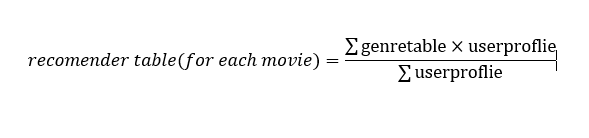

In [18]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.435115
2    0.300059
3    0.073400
4    0.195537
5    0.054610
dtype: float64

#### Sort our recommendations in descending order

In [19]:

recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
#Just a peek at the values
recommendationTable_df.head()

movieId
81132     0.595420
161594    0.591309
85261     0.584850
71999     0.569583
117646    0.561362
dtype: float64

### Print recommended movies

In [20]:
#The final recommendation table
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(20).keys())]

,movieId,title,genres,year
2260,3000,Princess Mononoke (Mononoke-hime),"[Action, Adventure, Animation, Drama, Fantasy]",1997
3680,5069,Escaflowne: The Movie (Escaflowne),"[Action, Adventure, Animation, Drama, Fantasy]",2000
4348,6350,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,"[Action, Adventure, Animation, Children, Fanta...",1986
5490,26340,"Twelve Tasks of Asterix, The (Les douze travau...","[Action, Adventure, Animation, Children, Comed...",1976
5533,26590,G.I. Joe: The Movie,"[Action, Adventure, Animation, Children, Fanta...",1987
5620,27155,"Batman/Superman Movie, The","[Action, Adventure, Animation, Children, Fanta...",1998
5819,32031,Robots,"[Adventure, Animation, Children, Comedy, Fanta...",2005
6448,51939,TMNT (Teenage Mutant Ninja Turtles),"[Action, Adventure, Animation, Children, Comed...",2007
6462,52462,Aqua Teen Hunger Force Colon Movie Film for Th...,"[Action, Adventure, Animation, Comedy, Fantasy...",2007
6881,62999,Madagascar: Escape 2 Africa,"[Action, Adventure, Animation, Children, Comed...",2008


# Maktabkhone Recommender System Project
- Author: Saeed Bagheri
- Github:  https://github.com/Saeedb7203